In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0,'..')
import matplotlib.pyplot as plt
import os.path
import prepare
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(16,10))
plt.rc('font', size=14)
pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_columns', 50)

In [2]:
if os.path.isfile('sso_dict.csv'):
    df_dict = pd.read_csv('sso_dict.csv')
else:
    url_sso_dict = '''https://storage.googleapis.com/sa_saws_data/SAWS_SSO_DataFieldDescription_MM.xlsx'''
    df_dict = pd.read_excel(url_sso_dict)
    df_dict.to_csv('sso_dict.csv', index=False)

In [3]:
df_dict

,Field,Data Description
0,SSO_ID,Internal ID
1,INSPKEY,Not Used
2,SERVNO,Service Req # (internal use only)
3,REPORTDATE,Date Reported
4,SPILL_ADDRESS,Street number of spill
5,SPILL_ST_NAME,Streen name of spill
6,TOTAL_GAL,Total gallons spilled
7,GALSRET,Gallons returned to collection system
8,GAL,Disregard
9,SPILL_START,When SAWS received information about the spill or arrived at the location


In [4]:
# df = acquire_sso.acquire_sso()

In [5]:
# df.head(1)

In [6]:
# df = prepare_sso.prepare_sso_df()
# df.head(1)

In [7]:
# df = prepare.prepare_sso_df()
# print(df.shape[0])
# df.head(1)

In [8]:
# df.columns = ['sso_id','report_date','spill_address_num','spill_st_name',
#  'total_gal','gals_ret','spill_start','spill_stop','hrs','cause',
#  'comments','actions','watershed','unit_id','unit_id2','discharge_to',
#  'discharge_route','council_district','month','year','week',
#  'earz_zone','pipe_diam','pipe_len','pipe_type','inst_year','inches_no',
#  'rainfall_last3','spill_address_full','num_spills_recorded',
#  'num_spills_24mos','prevspill_24mos','unit_type','asset_type',
#  'last_cleaned','response_time','response_dttm','public_notice',
#  'root_cause','hrs_2','gal_2','hrs_3','gal_3','days_since_cleaned']

In [9]:
# df.head(1)

In [10]:
# df.ResponseTime * 60

In [11]:
# df.shape

In [12]:
# df_dict.shape

In [13]:
# df_dict['Data Description'].value_counts()

In [14]:
# unused = ['Disregard','Ignore','Service Req # (internal use only)',
#           'Not Used','Old mapping system reference (internal only)']
# df_dict[df_dict['Data Description'].isin(unused)]

In [15]:
# ready1_dict = df_dict[~df_dict['Data Description'].isin(unused)]
# print(len(ready1_dict))
# ready1_dict

In [16]:
# null_fields = ['SPILL_START_2','SPILL_START_3',
#                'SPILL_STOP_2','SPILL_STOP_3']
# final_dict = ready1_dict[~ready1_dict.Field.isin(null_fields)]\
#                     .reset_index(drop=True)
# len(final_dict)

In [17]:
# final_dict

In [18]:
# features_to_use = list(final_dict.Field)
# len(features_to_use)

In [19]:
# bad_features = list(df.columns[~df.columns.isin(features_to_use)])

In [20]:
# df = df.drop(columns=bad_features)
# df = df.drop(columns = ['TIMEINT','STEPS_TO_PREVENT'])
# df.shape

In [21]:
# string_features = ['SSO_ID','SPILL_ADDRESS','COUNCIL_DISTRICT',]
# for col in string_features:
#     df[col] = df[col].astype(str)
    
# time_features = ['REPORTDATE','SPILL_START','SPILL_STOP',
#                  'ResponseDTTM', 'LASTCLND']
# for col in time_features:
#     df[col] = pd.to_datetime(df[col])
    
# fill_features = ['NUM_SPILLS_24MOS','PREVSPILL_24MOS','HRS_2',
#                 'HRS_3','GAL_2','GAL_3']
# for col in fill_features:
#     df[col] = df[col].fillna(0)
    
# df.Root_Cause = df.Root_Cause.str.strip()

In [22]:
# df['days_since_cleaned'] = (df.SPILL_START - df.LASTCLND).dt.days

In [23]:
# df['country_address'] = df.spill_address_full + \
#                                   ',SAN ANTONIO,Texas,USA'
# df.country_address

In [24]:
# df[['country_address']].head(25)

In [25]:
# for i in range(df.index.max()//5):
#     print([1*i+5, 2*i+5, 3*i + 5])

In [26]:
# lmo = pd.DataFrame()
# lmo['loc'] = ['string','fnish']
# lmo['was'] = [2,3]
# lmo.was[1] = 4
# lmo

In [27]:
# locator = Nominatim(user_agent="myGeocoder")
# geocode = RateLimiter(locator.geocode, min_delay_seconds=.1)
# test2 = pd.Series()

# counter = 10
# for i in range(0, df.index.max(), 10):
#     test = df[['country_address']][i:counter]
#     test['location'] = test['country_address'].apply(geocode)
#     test['zip_code'] = 'None'
#     for t,l in enumerate(test.location):
#         if l is not None:
#             test['zip_code'][counter+t-10] = l.raw['display_name']\
#                                     .split(',')[-2]
#     time.sleep(2)
#     test2 = test2.append(test.zip_code)
#     counter+=10
# test2

### Working

In [28]:
# locator = Nominatim(user_agent="myGeocoder")
# geocode = RateLimiter(locator.geocode, min_delay_seconds=.1, 
#                      max_retries=10, error_wait_seconds=1)
# df['location'] = df['country_address'].apply(geocode)
# df['zip_code'] = 'None'

In [29]:
# for t,l in enumerate(df.location):
#         if l is not None:
#             df['zip_code'][t] = l.raw['display_name']\
#                                     .split(',')[-2]

In [30]:
# df = prepare.prepare_sso_with_zipcodes()
# print(df.shape[0])
# df.head(1)

# Exploration

In [31]:
df = prepare.get_data()
print(df.shape)
df.head(1)

(3183, 75)


,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
0,6582,2019-03-10,3200,THOUSAND OAKS DR,2100,2100.0,2019-03-10 13:16:00,2019-03-10 14:40:00,1.4,Grease,"Spill ContainedReturned to SystemArea Cleaned and DisinfectedFlushed Area with H2O, Unstopped Main,",CLEANED MAIN,SALADO CREEK,66918,66917,STREET,None,NaN,3,2019,11,0,8.0,16.55,PVC,...,1.4,0.0,0.0,0.0,69.0,79,60,1,1,0,0,0,0,0.004286,0.005714,0.016333,54.285714,55.285714,54.2,65.857143,65.714286,64.533333,46.0,47.642857,45.9


In [32]:
df.root_cause.isna().sum()

0

In [33]:
df.root_cause.value_counts(dropna=False)

structural           1237
grease                611
debris                444
rain event            401
contractor            172
lift station          140
vandalism              72
other                  69
roots                  22
i/i                    12
by pass pump leak       3
Name: root_cause, dtype: int64

In [34]:
train, test = train_test_split(df, random_state=42, train_size=.8,
                              stratify=df.root_cause)

In [35]:
train.zip_code.value_counts().head(5)

None     754
Texas    231
78228     93
78223     84
78209     76
Name: zip_code, dtype: int64

In [36]:
train.isna().sum()

sso_id                 0
report_date            0
spill_address_num      0
spill_st_name          0
total_gal              0
                      ..
max_temp_rolling_14    0
max_temp_rolling_30    0
min_temp_rolling_7     0
min_temp_rolling_14    0
min_temp_rolling_30    0
Length: 75, dtype: int64

In [37]:
train.spill_address_full.head(15)

434     11780 Parliament  Over The Edwards Aquifer Transition Zone
871                                                1830 LENNON AVE
2175                                                5500 Cagnon Rd
1588                                             1910 Catalina Ave
724                                                  YOLANDA 00111
10                                                  5 Trophy Ridge
219                                                      2600 CIMA
2327                               3440 Fredericksburg Rd In Front
207                                               515 Woodcrest Dr
1438                                                    210 Tuleta
3                                              3602 SE MILITARY DR
284                                             1900 Blue Crest Ln
1631                6931 Alan Hale Dr  ( Into Dry Zarzamora Creek)
601                                                    139 Prelude
348                                                  111 DALLA

In [38]:
train.days_since_cleaned.dropna()

2327    533.0
1887     54.0
1427    245.0
2000    167.0
2726     91.0
        ...  
2731     32.0
2123    169.0
1955    371.0
1201      0.0
2497     34.0
Name: days_since_cleaned, Length: 882, dtype: float64

In [39]:
train[train.days_since_cleaned == train.days_since_cleaned.max()]

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
1020,3555,2015-02-23,3,VILLA VERDE,200,0.0,2015-02-23 15:28:00,2015-02-23 16:46:00,1.3,Grease,"Spill ContainedArea Cleaned and DisinfectedFlushed Area with H2O, Unstopped Main,",CLEANED MAIN,DOS RIOS,6169,6157,DRAINAGE CULVERT,None,8.0,2,2015,9,0,8.0,400.0,VCP,...,1.3,0.0,0.0,0.0,39.0,41,32,0,0,0,0,0,0,1.055703e-16,0.005714,0.022333,53.857143,57.214286,56.2,65.0,68.142857,67.433333,42.571429,45.357143,45.233333


In [40]:
features = df.isna().sum() / df.shape[0]
bad_list = features[features > .4]
print(len(bad_list))
bad_list

4


last_cleaned          0.654100
response_time         0.607603
response_dttm         0.607603
days_since_cleaned    0.654100
dtype: float64

In [41]:
train.drop(columns='hours_spilled')\
    .describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,sso_id,spill_address_num,total_gal,gals_ret,hrs,council_district,month,year,week,pipe_diam,pipe_len,inches_no,rainfall_last3,num_spills_recorded,num_spills_24mos,response_time,hrs_2,gal_2,hrs_3,gal_3,days_since_cleaned,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
count,2546.000000,2546.000000,2546.000000,2178.000000,2543.000000,2288.000000,2546.000000,2546.000000,2546.000000,2393.000000,2393.000000,2158.000000,2117.000000,2546.000000,2546.000000,1018.000000,2546.000000,2546.000000,2546.000000,2546.000000,882.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000
mean,3341.567557,4285.021603,31895.417125,3047.653811,4.432720,5.003059,6.272977,2012.937549,25.993716,11.387589,287.002141,0.471979,0.499655,1.925373,0.730558,-281.670923,0.239017,3789.840141,0.027503,187.827965,259.476190,0.415373,0.001218,0.000786,68.522781,79.120974,58.458759,0.385703,0.043205,0.162608,0.083661,0.011783,0.166143,0.183623,0.143606,0.119295,68.781702,68.899057,68.936207,79.489115,79.692852,79.804569,58.693244,58.740882,58.691307
std,1890.664846,4632.791262,223165.355712,55579.479139,40.662691,3.068449,3.587650,2.962441,15.619165,10.282999,444.208683,1.310179,1.029894,2.136209,1.166521,10033.429465,2.919121,62384.538180,0.505360,5421.000616,297.733489,1.226946,0.040070,0.039637,13.493754,13.876564,14.469508,0.486857,0.203358,0.369080,0.276933,0.107930,0.372282,0.302246,0.183799,0.111148,12.926202,12.699947,12.470677,13.022915,12.763675,12.497217,13.574862,13.250989,12.943708
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2009.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-319950.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,24.000000,29.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.285714,42.178571,46.466667,47.142857,50.000000,55.333333,25.000000,26.642857,33.700000
25%,2106.250000,700.000000,50.000000,0.000000,0.750000,2.000000,3.000000,2010.000000,12.000000,8.000000,136.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.000000,0.000000,0.000000,0.000000,59.000000,70.000000,47.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010714,0.031667,57.857143,57.500000,56.950000,69.714286,69.285714,68.900000,46.607143,46.428571,46.500000
50%,2913.500000,2600.000000,249.500000,0.000000,1.416667,5.000000,6.000000,2012.000000,24.000000,8.000000,264.800000,0.000000,0.000000,1.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,163.500000,0.000000,0.000000,0.000000,70.500000,80.000000,61.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034286,0.067143,0.088667,69.928571,69.714286,70.058333,80.285714,80.500000,80.666667,59.714286,59.571429,59.116667
75%,5791.500000,6785.000000,2350.000000,0.000000,2.816667,8.000000,9.000000,2016.000000,40.000000,8.000000,351.800000,0.090000,0.460000,2.000000,1.000000,54.000000,0.000000,0.000000,0.000000,0.000000,372.000000,0.050000,0.000000,0.000000,79.500000,89.000000,71.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.249286,0.226429,0.170000,79.785714,80.116071,79.966667,89.857143,90.071429,90.566667,71.714286,71.428571,70.866667
max,6584.000000,28194.000000,6026731.000000,2385150.000000,1796.000000,10.000000,12.000000,2019.000000,53.000000,66.000000,11689.350000,9.870000,12.200000,21.000000,11.000000,3020.000000,118.000000,2377350.000000,15.530000,25530

In [42]:
len(train.report_date.unique())

1620

In [43]:
train[train.num_spills_recorded == train.num_spills_recorded.max()]

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
71,6512,2018-11-13,606,N ALAMO ST,2080,0.0,2018-11-13 08:16:00,2018-11-13 10:00:00,1.733333,Contractor,NaN,REMOVED BYPASS,DOS RIOS,STMDRAIN,NaN,STORMDRAIN - Then entered the San Antonio River,SAN ANTONIO RIVER,NaN,11,2018,46,0,NaN,NaN,unknown,...,1.733333,0.0,0.0,0.0,40.0,48,28,0,0,0,0,0,0,2.300000e-01,0.182857,0.202667,55.428571,60.214286,60.866667,59.857143,67.642857,69.166667,47.714286,51.000000,52.866667
716,5863,2016-04-23,4006,BRIARGLEN,6000,NaN,2016-04-22 21:00:00,2016-04-22 23:00:00,2.000000,Other,NaN,REPAIRED PUMP,SALADO CREEK,46429,46423,CREEK BED - SPILLED INTO BEITEL CREEK,BEITEL CREEK,NaN,4,2016,17,0,NaN,NaN,unknown,...,2.000000,0.0,0.0,0.0,70.0,81,56,0,0,0,0,0,0,3.785714e-01,0.358571,0.172667,71.428571,70.142857,67.300000,80.428571,79.642857,78.000000,62.714286,62.285714,56.866667
800,5774,2015-12-22,5704,PRESA ST S,90,NaN,2015-12-21 11:16:00,2015-12-21 18:00:00,6.733333,Structural,"Repaired main, 10"" sewer main",REPAIRED MAIN,DOS RIOS,NaN,NaN,DRAINAGE CULVERT,NONE,3.0,12,2015,52,0,NaN,NaN,unknown,...,6.733333,0.0,0.0,0.0,62.0,79,48,0,0,0,0,0,0,3.172066e-16,0.052857,0.102333,56.857143,60.285714,57.666667,69.142857,72.928571,69.466667,43.857143,47.571429,46.000000


In [44]:
train[train.total_gal.isin(list(train.total_gal.nlargest(8)))]

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
2338,18,2010-10-20,8600,MISSION PKWY,4442000,NaN,2010-10-20 09:00:00,2010-10-27 11:00:00,170.00,Break In Main,REPAIRED FORCE MAIN - L/S # 172,REPAIRED BROKEN MAIN,DOS RIOS,13440,14063,CREEK BED,SAN ANTONIO RIVER,3.0,10,2010,43,0,30.0,122.58,FRP,...,170.000000,0.00,0.0,0.0,74.0,85,63,0,0,0,0,0,0,0.000000,0.006429,0.017667,69.857143,70.285714,72.083333,82.857143,83.428571,84.200000,56.857143,57.142857,59.966667
2771,1796,2010-01-15,300,PETALUMA BLVD E,3570000,NaN,2010-01-15 02:00:00,2010-01-16 03:00:00,25.00,I/I,"ADDED 18"" BY PASS",ADDED BY PASS,DOS RIOS,16451,20815,CREEK BED,SIX MILE CREEK,3.0,1,2010,3,0,36.0,1005.00,RCP,...,25.000000,1.81,0.0,0.0,51.0,56,46,1,0,0,1,0,1,0.511429,0.255714,0.150667,45.500000,43.500000,46.900000,55.000000,52.785714,57.133333,36.000000,34.214286,36.666667
647,5943,2016-06-02,6606,SWISS OAKS,2050500,0.0,2016-06-02 11:45:00,2016-06-06 12:30:00,96.75,I/I,NaN,DILUTED BY HEAVY RAINWATER,LEON CREEK,903064,903061,CREEK BED - SPILLED INTO LEON CREEK,LEON CREEK,6.0,6,2016,23,0,0.0,16.81,,...,96.750000,2.34,0.0,0.0,74.0,85,66,1,0,1,0,0,0,0.941429,0.471429,0.382333,77.285714,77.500000,75.166667,88.000000,87.071429,84.566667,67.285714,69.928571,67.100000
84,6499,2018-10-24,108,CHAPPIE JAMES WAY,2448400,0.0,2018-10-24 13:50:00,2018-10-28 13:29:00,95.65,I/I,NaN,MONITORED AREA,LEON CREEK,1210,42319,CREEK BED - Spilled Into Leon Creek,LEON CREEK,NaN,10,2018,43,0,54.0,1335.00,RCP,...,95.650000,0.79,0.0,0.0,59.0,63,55,1,0,0,0,0,0,0.282857,0.254286,0.185333,60.000000,62.928571,70.533333,65.571429,70.000000,78.100000,55.428571,57.428571,64.700000
688,5888,2016-05-18,700,HOLBROOK,2754790,0.0,2016-05-17 18:28:00,2016-05-21 03:00:00,80.53,I/I,NaN,DILUTED BY HEAVY RAINWATER,SALADO CREEK,990827,48236,CREEK BED - Spilled Into Salado Creek,SALADO CREEK,2.0,5,2016,21,0,0.0,0.00,,...,80.533333,0.14,0.0,0.0,71.0,78,63,0,0,1,0,0,0,0.292857,0.214286,0.155333,73.285714,73.928571,73.000000,79.857143,82.500000,82.466667,67.000000,65.714286,63.666667
504,6062,2016-12-03,108,CHAPPIE JAMES WAY,1880100,0.0,2016-12-03 09:24:00,2016-12-04 09:00:00,23.60,I/I,NaN,Diluted By Heavy Rain Water,LEON CREEK,462766,1210,CREEK BED - Spilled Into Leon Creek,LEON CREEK,0.0,12,2016,49,0,54.0,17.18,CSC,...,23.600000,3.84,0.0,0.0,53.0,53,50,1,0,1,0,0,0,0.642857,0.321429,0.207667,60.857143,60.785714,63.833333,70.142857,71.642857,73.933333,49.285714,49.500000,53.933333
646,5942,2016-06-02,700,HOLBROOK,6026731,0.0,2016-06-02 11:09:00,2016-06-06 07:30:00,92.35,I/I,NaN,DILUTED BY HEAVY RAINWATER,SALADO CREEK,47822,922726,CREEK BED - SPILLED INTO SALADO CREEK,SALADO CREEK,2.0,6,2016,23,0,0.0,5.89,,...,92.350000,2.34,0.0,0.0,74.0,85,66,1,0,1,0,0,0,0.941429,0.471429,0.382333,77.285714,77.500000,75.166667,88.000000,87.071429,84.566667,67.285714,69.928571,67.100000
653,5922,2016-05-31,108,CHAPPIE JAMES WAY,2453340,0.0,2016-05-31 17:08:00,2016-06-01 07:02:00,13.90,I/I,NaN,DILUTED BY HEAVY RAINWATER,LEON CREEK,1187,1074,CREEK BED - SPILLED INTO LEON CREEK,LEON CREEK,NaN,5,2016,23,0,54.0,17.61,CSC,...,13.900000,1.84,0.0,0.0,77.0,85,67,1,0,1,0,0,0,0.607143,0.447857,0.304333,79.285714,76.714286,74.633333,89.142857,85.928571,83.866667,70.285714,69.285714,66.466667


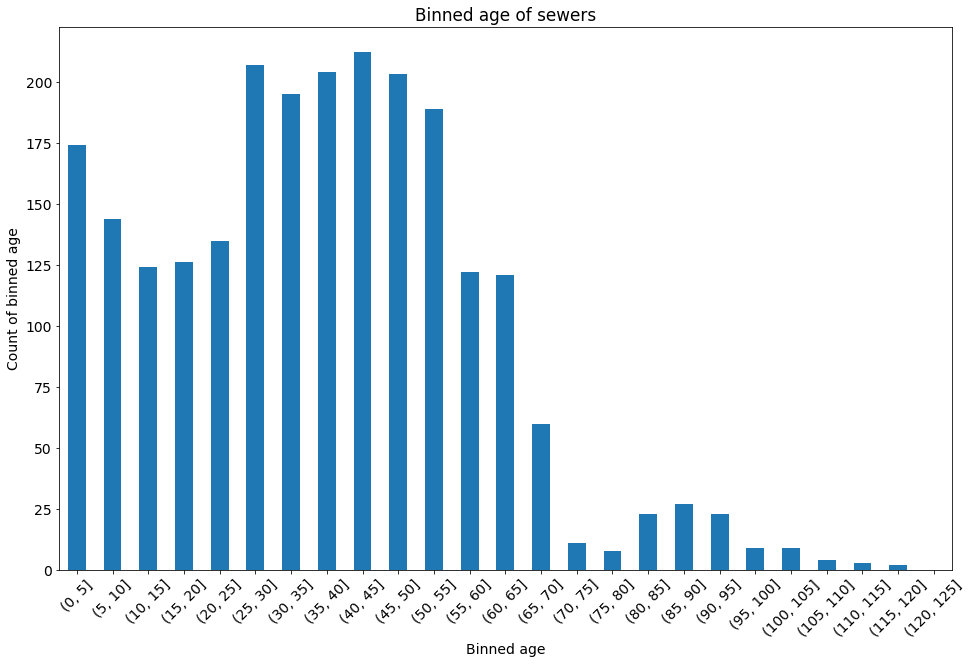

In [45]:
train.age_binned.dropna().value_counts().sort_index().plot.bar()
plt.xticks(rotation=45)

plt.ylabel('Count of binned age')
plt.xlabel('Binned age')
plt.title('Binned age of sewers')
plt.show()

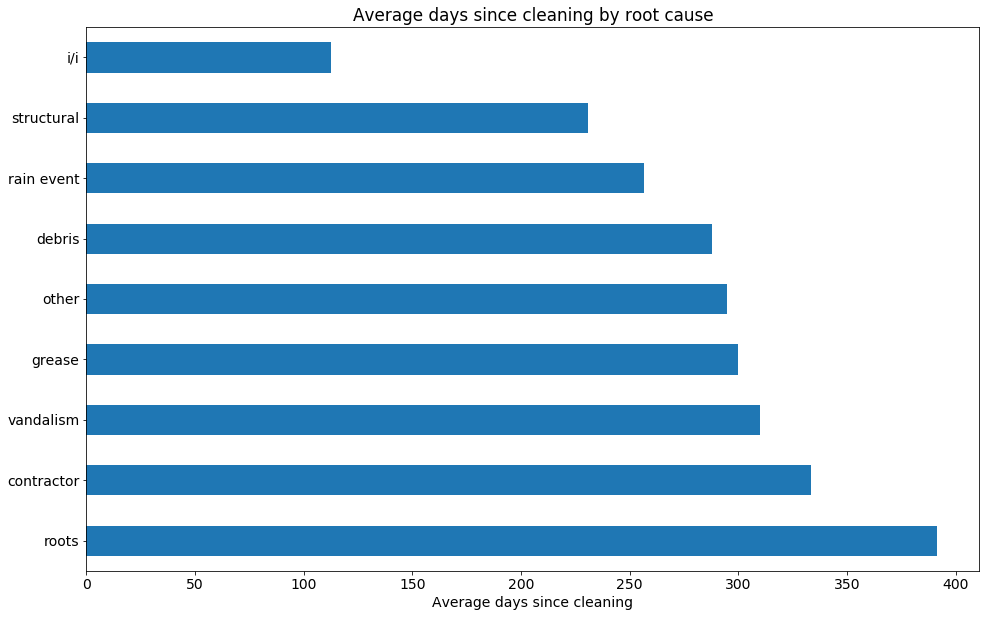

In [46]:
ax = train.groupby('root_cause').days_since_cleaned.mean()\
    .sort_values(ascending=False).dropna().plot.barh()
ax.set_ylabel('')
ax.set_xlabel('Average days since cleaning')
plt.title('Average days since cleaning by root cause')
plt.show()

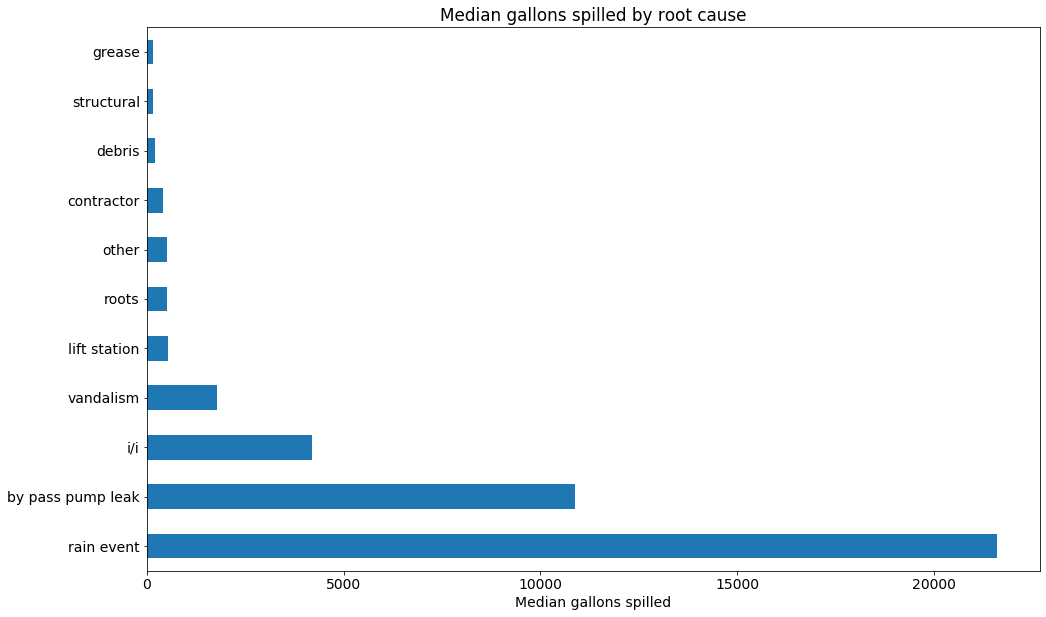

In [47]:
ax = train.groupby('root_cause').total_gal.median()\
    .sort_values(ascending=False).dropna().plot.barh()
ax.set_ylabel('')
ax.set_xlabel('Median gallons spilled')
plt.title('Median gallons spilled by root cause')
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

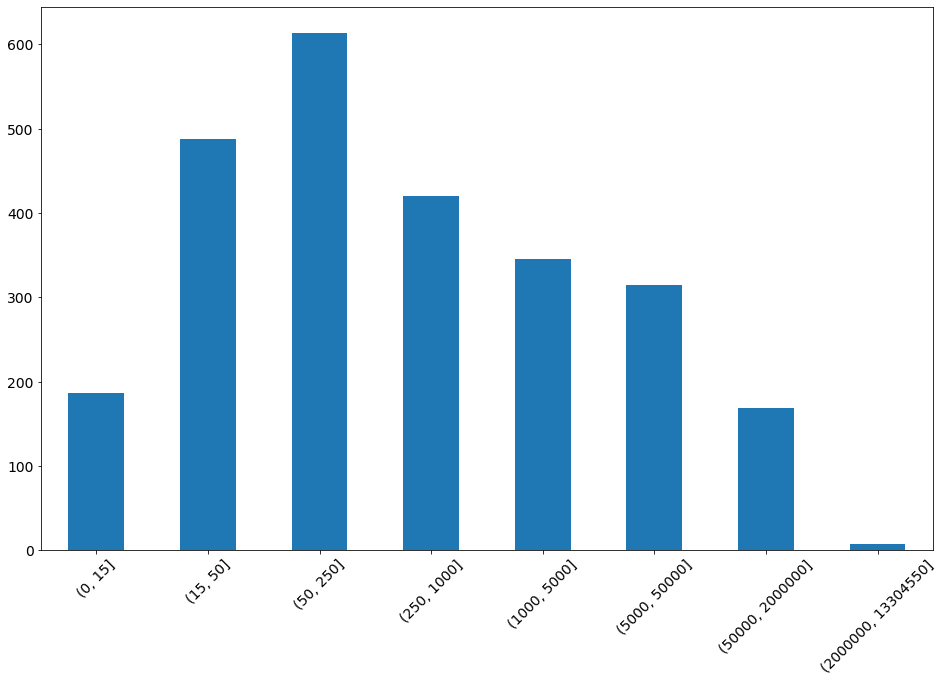

In [48]:
train['total_gal_binned'].value_counts().sort_index().plot.bar()
plt.xticks(rotation=45)

In [49]:
train[train.days_since_cleaned == train.days_since_cleaned.max()]

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
1020,3555,2015-02-23,3,VILLA VERDE,200,0.0,2015-02-23 15:28:00,2015-02-23 16:46:00,1.3,Grease,"Spill ContainedArea Cleaned and DisinfectedFlushed Area with H2O, Unstopped Main,",CLEANED MAIN,DOS RIOS,6169,6157,DRAINAGE CULVERT,None,8.0,2,2015,9,0,8.0,400.0,VCP,...,1.3,0.0,0.0,0.0,39.0,41,32,0,0,0,0,0,0,1.055703e-16,0.005714,0.022333,53.857143,57.214286,56.2,65.0,68.142857,67.433333,42.571429,45.357143,45.233333


In [50]:
train[train.inst_year == train.inst_year.max()].shape

(106, 75)

In [51]:
train.groupby('age_binned').total_gal.median()\
    .sort_values(ascending=False)

age_binned
(115, 120]    4375.0
(110, 115]    3000.0
(10, 15]      1395.0
(40, 45]      1000.0
(30, 35]       500.0
(35, 40]       500.0
(95, 100]      450.0
(105, 110]     390.0
(5, 10]        390.0
(25, 30]       390.0
(15, 20]       300.0
(65, 70]       250.5
(0, 5]         250.0
(50, 55]       200.0
(70, 75]       200.0
(20, 25]       200.0
(45, 50]       195.0
(75, 80]       175.0
(55, 60]       145.0
(60, 65]       100.0
(85, 90]       100.0
(90, 95]       100.0
(100, 105]     100.0
(80, 85]        50.0
(120, 125]       NaN
Name: total_gal, dtype: float64

In [52]:
train.root_cause.value_counts()

structural           989
grease               489
debris               355
rain event           321
contractor           137
lift station         112
vandalism             58
other                 55
roots                 18
i/i                   10
by pass pump leak      2
Name: root_cause, dtype: int64

In [53]:
train.head(1)

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,...,hours_spilled,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
434,6144,2017-03-31,11780,PARLIAMENT,6100,0.0,2017-03-31 09:58:00,2017-03-31 12:00:00,2.033333,Grease,"Spill ContainedArea Cleaned and DisinfectedFlushed Area with H2O, Unstopped Main,",CLEANED MAIN,SALADO CREEK,67605,53038,STORMDRAIN - Over The Edwards Aquifer Transition Zone,None,9.0,3,2017,13,0,8.0,281.0,PVC,...,2.033333,0.0,0.0,0.0,69.0,86,52,0,0,0,0,0,0,0.124286,0.062143,0.069667,71.142857,71.142857,66.833333,83.571429,82.785714,77.0,59.285714,60.642857,58.166667


In [54]:
train[train.root_cause == 'other']['cause'].value_counts()

Other                                                   13
Grease                                                   9
Debris                                                   8
Other - Capacity                                         5
Structural                                               4
Plug In Main                                             4
By-pass Pump Failure                                     2
I/I                                                      2
By-Pass Equip Failure                                    2
Human Error                                              1
Other - Spill Was Caused By A Surcharging Sewer Main     1
Contractor                                               1
Broken ARV                                               1
By-Pass Pump Failure                                     1
Other - Cause To Be Determined                           1
Name: cause, dtype: int64

In [55]:
top_worst_spills = train[train.total_gal.isin(
                            train.total_gal.nlargest(15))]
top_worst_spills[['age_binned','total_gal']]\
    .sort_values('total_gal', ascending=False)

,age_binned,total_gal
646,"(40.0, 45.0]",6026731
2338,"(15.0, 20.0]",4442000
2771,"(60.0, 65.0]",3570000
688,"(0.0, 5.0]",2754790
653,"(30.0, 35.0]",2453340
84,"(50.0, 55.0]",2448400
647,"(0.0, 5.0]",2050500
504,"(30.0, 35.0]",1880100
112,"(50.0, 55.0]",1640538
695,"(30.0, 35.0]",1527175


In [56]:
top_bins = top_worst_spills.sort_values(by='total_gal', 
                        ).age_binned.value_counts()
top_bins[top_bins>0]

(0, 5]      4
(50, 55]    3
(30, 35]    3
(40, 45]    2
(15, 20]    1
(60, 65]    1
Name: age_binned, dtype: int64

In [57]:
train.groupby('age_binned').total_gal.mean()\
            .dropna().sort_values().tail(6)

age_binned
(60, 65]     32023.148760
(15, 20]     42206.603175
(30, 35]     56013.994872
(50, 55]     56520.216931
(0, 5]       63933.298851
(40, 45]    103412.000000
Name: total_gal, dtype: float64

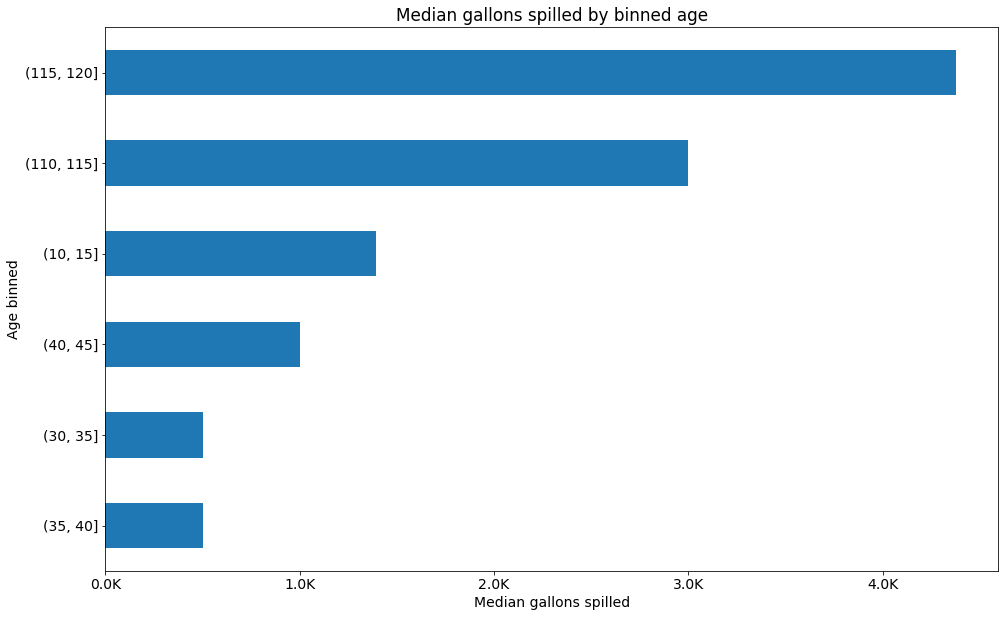

In [58]:
ax = train.groupby('age_binned').total_gal.median()\
            .dropna().sort_values().tail(6).plot.barh()
xlabels = ['{:,.1f}'.format(x) +'K' 
                   for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
ax.set_xlabel('Median gallons spilled')
ax.set_ylabel('Age binned')
plt.title('Median gallons spilled by binned age')
plt.show()

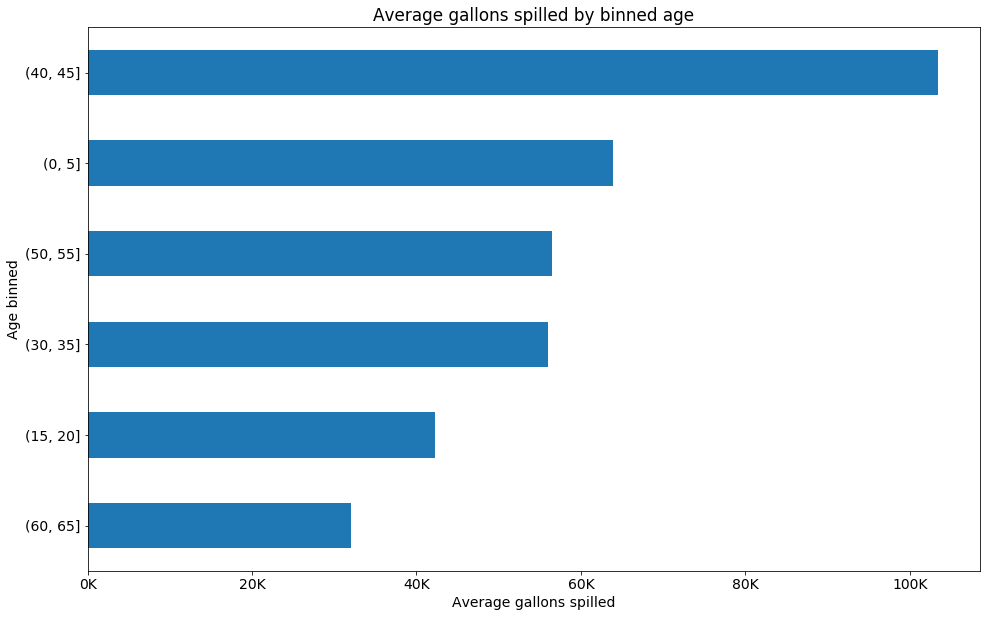

In [59]:
ax = train.groupby('age_binned').total_gal.mean()\
            .dropna().sort_values().tail(6).plot.barh()
xlabels = ['{:,.0f}'.format(x) +'K' 
                   for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
ax.set_xlabel('Average gallons spilled')
ax.set_ylabel('Age binned')
plt.title('Average gallons spilled by binned age')
plt.show()

In [60]:
# num_spills_recorded, num_spills_24mos

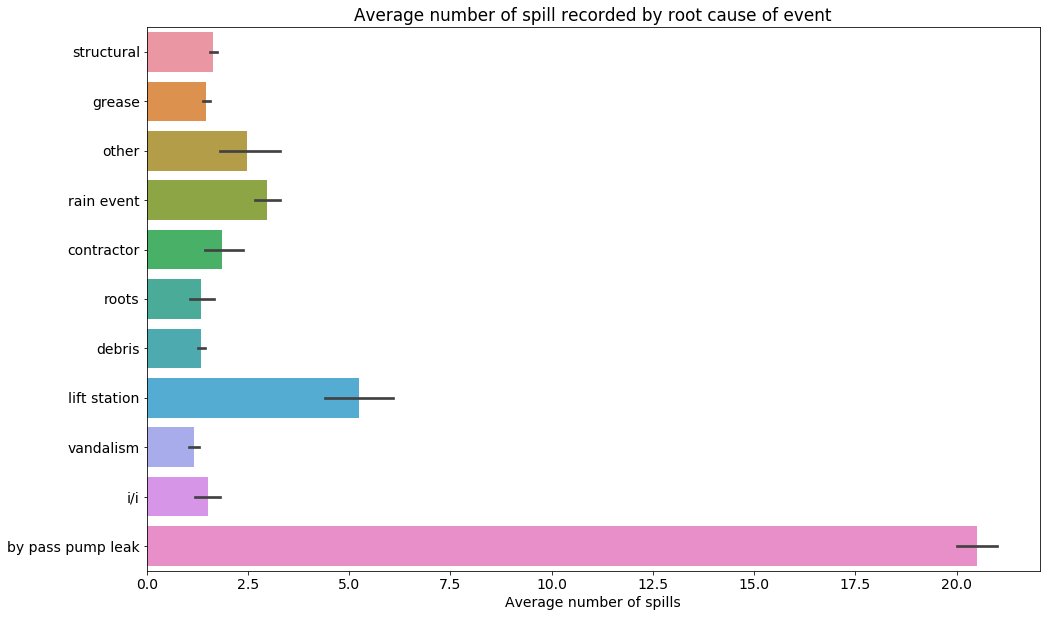

In [61]:
sns.barplot(train.num_spills_recorded, train.root_cause)
plt.xlabel('Average number of spills')
plt.ylabel('')
plt.title('Average number of spill recorded by root cause of event')
plt.show()

In [62]:
# train.groupby('root_cause').num_spills_24mos.sum()
df.root_cause.value_counts()

structural           1237
grease                611
debris                444
rain event            401
contractor            172
lift station          140
vandalism              72
other                  69
roots                  22
i/i                    12
by pass pump leak       3
Name: root_cause, dtype: int64

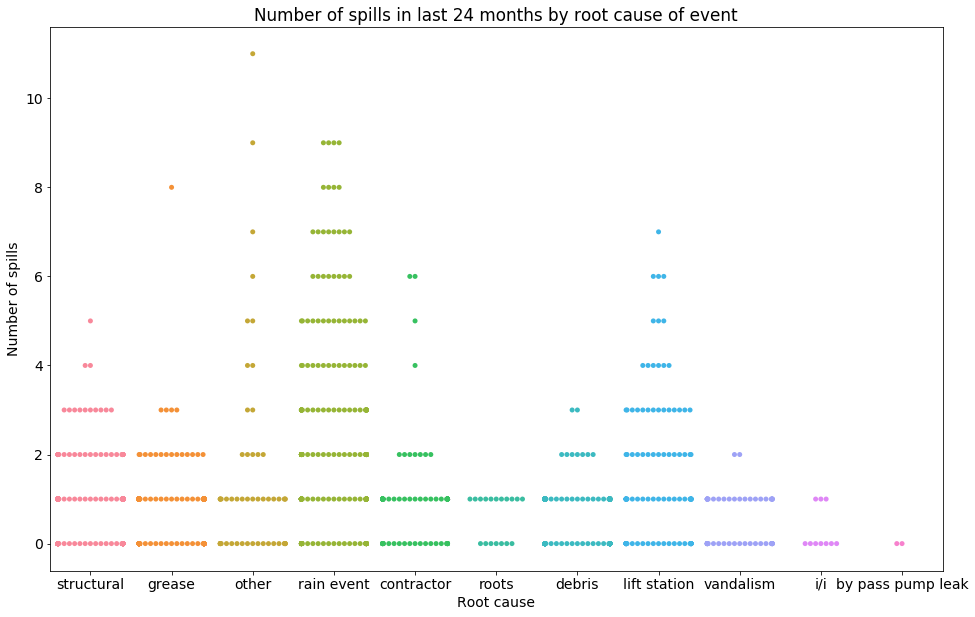

In [63]:
sns.swarmplot(train.root_cause, train.num_spills_24mos)
plt.xlabel('Root cause')
plt.ylabel('Number of spills')
plt.title(
'Number of spills in last 24 months by root cause of event')
plt.show()

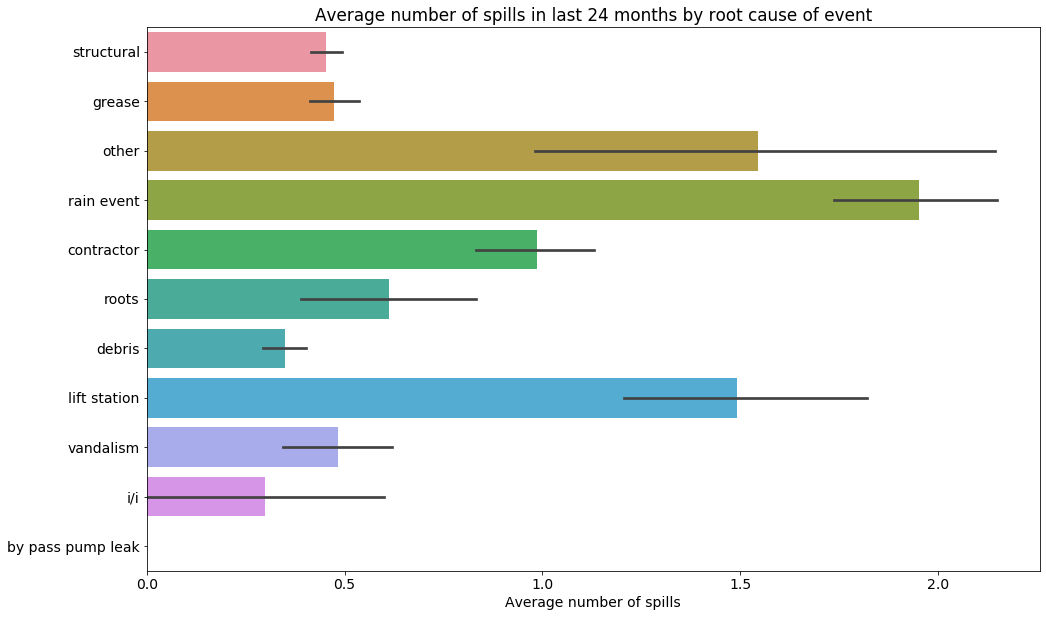

In [64]:
sns.barplot(train.num_spills_24mos, train.root_cause)
plt.xlabel('Average number of spills')
plt.ylabel('')
plt.title(
'Average number of spills in last 24 months by root cause of event')
plt.show()

## Make data useable for modeling

In [65]:
list(df.columns)

['sso_id',
 'report_date',
 'spill_address_num',
 'spill_st_name',
 'total_gal',
 'gals_ret',
 'spill_start',
 'spill_stop',
 'hrs',
 'cause',
 'comments',
 'actions',
 'watershed',
 'unit_id',
 'unit_id2',
 'discharge_to',
 'discharge_route',
 'council_district',
 'month',
 'year',
 'week',
 'earz_zone',
 'pipe_diam',
 'pipe_len',
 'pipe_type',
 'inst_year',
 'inches_no',
 'rainfall_last3',
 'spill_address_full',
 'num_spills_recorded',
 'num_spills_24mos',
 'prevspill_24mos',
 'unit_type',
 'asset_type',
 'last_cleaned',
 'response_time',
 'response_dttm',
 'public_notice',
 'root_cause',
 'hrs_2',
 'gal_2',
 'hrs_3',
 'gal_3',
 'days_since_cleaned',
 'total_gal_binned',
 'country_address',
 'location',
 'zip_code',
 'age',
 'age_binned',
 'hours_spilled',
 'precipitation',
 'snowfall',
 'snow_depth',
 'avg_temp',
 'max_temp',
 'min_temp',
 'foggy',
 'heavy_fog',
 'thunder',
 'hail',
 'blowing_snow',
 'rain',
 'precipitation_rolling_7',
 'precipitation_rolling_14',
 'precipitation_ro

In [66]:
# df.inst_year = df.inst_year[df.inst_year!='unknown']

In [67]:
# df.last_cleaned.value_counts()

In [68]:
# unwanted = ['spill_st_name','comments','actions','discharge_to',
#            'discharge_route','spill_address_full','prevspill_24mos',
#            'last_cleaned','country_address','location']
# categorical_columns = [col for col in list(
#                 df.dtypes[df.dtypes=='O'].index) 
#                  if col not in unwanted]

In [69]:
columns_to_drop_from_model = [
    "sso_id","report_date","spill_address_num","spill_st_name",
    "spill_stop","spill_start","cause","comments","actions",
    "month","year","week","spill_address_full","last_cleaned",
    "response_dttm","prevspill_24mos","public_notice",
    "country_address","location","inches_no","rainfall_last3",
    "unit_id","unit_id2","zip_code","discharge_to","discharge_route",
    "council_district","hours_spilled","hrs","gals_ret","pipe_diam",
    "pipe_len","response_time","days_since_cleaned","age"
]

df2 = df.copy().drop(columns=columns_to_drop_from_model)
print(df2.shape)
df2.head(1)

(3183, 40)


,total_gal,watershed,earz_zone,pipe_type,inst_year,num_spills_recorded,num_spills_24mos,unit_type,asset_type,root_cause,hrs_2,gal_2,hrs_3,gal_3,total_gal_binned,age_binned,precipitation,snowfall,snow_depth,avg_temp,max_temp,min_temp,foggy,heavy_fog,thunder,hail,blowing_snow,rain,precipitation_rolling_7,precipitation_rolling_14,precipitation_rolling_30,avg_temp_rolling_7,avg_temp_rolling_14,avg_temp_rolling_30,max_temp_rolling_7,max_temp_rolling_14,max_temp_rolling_30,min_temp_rolling_7,min_temp_rolling_14,min_temp_rolling_30
0,2100,SALADO CREEK,0,PVC,1997.0,1,1.0,GRAVITY,Sewer Main,other,0.0,0.0,0.0,0.0,"(1000, 5000]","(20, 25]",0.0,0.0,0.0,69.0,79,60,1,1,0,0,0,0,0.004286,0.005714,0.016333,54.285714,55.285714,54.2,65.857143,65.714286,64.533333,46.0,47.642857,45.9


In [70]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

categorical_columns = [
    "watershed",
    "earz_zone",
    "pipe_type",
    "inst_year",
    "unit_type",
    "asset_type",
    "age_binned",
    "total_gal_binned"
    
]

for column in categorical_columns:
    if is_numeric_dtype(df2[f"{column}"]):
        values = df2[f"{column}"].unique()
        for value in values:
            df2[f"{column}_is_{value}"]=(df2[f"{column}"] == value)\
                    .astype(int)
        df2 = df2.drop(columns=column)
    elif is_string_dtype(df2[f"{column}"]):
        values = df2[f"{column}"].astype(str).str.lower().unique()
        for value in values:
            df2[f"{column}_is_{value}"]=(df2[f"{column}"] == value)\
                .astype(int)
        df2 = df2.drop(columns=column)

In [71]:
X = df2.drop(columns='root_cause')
y = df2.root_cause

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=.8, random_state=42)
X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, train_size=.6,
                     random_state=42)

In [72]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, precision_score, \
                classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

### Decision Tree

In [73]:
params = {'max_depth': range(1,11), 'min_samples_leaf': range(1,8),
          'criterion': ['gini', 'entropy']}
model = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(model, params, cv=4, iid=True)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 4}


In [74]:
results = grid.cv_results_
for score, p in zip(results['mean_test_score'], results['params']):
    p['score'] = score
pd.DataFrame(results['params']).sort_values('score').tail(5)

,criterion,max_depth,min_samples_leaf,score
15,gini,3,2,0.502947
20,gini,3,7,0.503602
19,gini,3,6,0.503602
18,gini,3,5,0.503602
17,gini,3,4,0.503602


In [75]:
tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=4,
                              random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_train)
print(f'Accuracy Score on Train: \
    {tree.score(X_train, y_train) * 100:.2f}%')
print(f'Accuracy Score on Val: \
    {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score on Train:     51.28%
Accuracy Score on Val:     50.34%


In [76]:
pd.DataFrame(classification_report(y_train, y_pred,
                                   output_dict=True)).T

,precision,recall,f1-score,support
by pass pump leak,0.000000,0.000000,0.000000,2.00000
contractor,0.000000,0.000000,0.000000,82.00000
debris,0.000000,0.000000,0.000000,211.00000
grease,0.000000,0.000000,0.000000,294.00000
i/i,0.000000,0.000000,0.000000,9.00000
lift station,0.888889,0.800000,0.842105,70.00000
other,0.000000,0.000000,0.000000,33.00000
rain event,0.729592,0.790055,0.758621,181.00000
roots,0.000000,0.000000,0.000000,9.00000
structural,0.460568,0.963696,0.623266,606.00000


### Logistic Regression

In [77]:
model = LogisticRegression(random_state = 42).fit(X_train, y_train)
y_pred = model.predict(X_train)
y_pred_prob = model.predict_proba(X_train)

print(f'Accuracy Score on Train: \
    {model.score(X_train, y_train) * 100:.2f}%')
print(f'Accuracy Score on Val: \
    {model.score(X_val, y_val) * 100:.2f}%')

Accuracy Score on Train:     42.11%
Accuracy Score on Val:     39.65%


In [78]:
pd.DataFrame(classification_report(y_train, y_pred,
                                   output_dict=True)).T

,precision,recall,f1-score,support
by pass pump leak,0.000000,0.000000,0.000000,2.000000
contractor,0.000000,0.000000,0.000000,82.000000
debris,0.000000,0.000000,0.000000,211.000000
grease,0.000000,0.000000,0.000000,294.000000
i/i,0.000000,0.000000,0.000000,9.000000
lift station,0.000000,0.000000,0.000000,70.000000
other,0.000000,0.000000,0.000000,33.000000
rain event,0.681818,0.248619,0.364372,181.000000
roots,0.000000,0.000000,0.000000,9.000000
structural,0.409309,0.986799,0.578616,606.000000


### Random Forest

In [79]:
params = {'max_depth': range(1,11), 'min_samples_leaf': range(1,6),
          'criterion': ['gini', 'entropy']}
model = RandomForestClassifier(random_state=42)
grid = GridSearchCV(model, params, cv=4, iid=True)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1}


In [80]:
results = grid.cv_results_
for score, p in zip(results['mean_test_score'], results['params']):
    p['score'] = score
pd.DataFrame(results['params']).sort_values('score').tail(5)

,criterion,max_depth,min_samples_leaf,score
86,entropy,8,2,0.494434
40,gini,9,1,0.496398
41,gini,9,2,0.496398
45,gini,10,1,0.496398
95,entropy,10,1,0.499673


In [81]:
# forest = RandomForestClassifier(random_state=42, 
#     min_samples_leaf=1, max_depth=10, 
#     criterion='entropy').fit(X_train, y_train)
forest = RandomForestClassifier(random_state=42, min_samples_leaf=2,
                               max_depth=9).fit(X_train, y_train)
y_pred = forest.predict(X_train)
print(f'Accuracy Score on Train: \
    {forest.score(X_train, y_train) * 100:.2f}%')
print(f'Accuracy Score on Val: \
    {forest.score(X_val, y_val) * 100:.2f}%')

Accuracy Score on Train:     56.45%
Accuracy Score on Val:     49.66%


In [82]:
pd.DataFrame(classification_report(y_train, y_pred,
                                   output_dict=True)).T

,precision,recall,f1-score,support
by pass pump leak,0.000000,0.000000,0.000000,2.000000
contractor,0.000000,0.000000,0.000000,82.000000
debris,1.000000,0.023697,0.046296,211.000000
grease,0.977778,0.149660,0.259587,294.000000
i/i,0.000000,0.000000,0.000000,9.000000
lift station,0.979592,0.685714,0.806723,70.000000
other,1.000000,0.121212,0.216216,33.000000
rain event,0.799043,0.922652,0.856410,181.000000
roots,0.000000,0.000000,0.000000,9.000000
structural,0.488889,0.980198,0.652389,606.000000


### KNeighbors Classifier

In [83]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), 
                      columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), 
                        columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                        columns=X_test.columns, index=X_test.index)

In [ ]:
params = {'n_neighbors': range(1,11), 'p': range(1,5),
          'weights': ['uniform', 'distance']}
model = KNeighborsClassifier()
grid = GridSearchCV(model, params, cv=4, iid=True)
grid.fit(X_train_scaled, y_train)
print(grid.best_params_)

In [ ]:
results = grid.cv_results_
for score, p in zip(results['mean_test_score'], results['params']):
    p['score'] = score
pd.DataFrame(results['params']).sort_values('score').tail(5)

In [ ]:
knmodel = KNeighborsClassifier(n_neighbors= 10, p= 4, 
                weights = 'uniform').fit(X_train_scaled, y_train)
y_pred = knmodel.predict(X_train_scaled)

print(f'Accuracy Score on Train: \
    {knmodel.score(X_train_scaled, y_train) * 100:.2f}%')
print(f'Accuracy Score on Val: \
    {knmodel.score(X_val_scaled, y_val) * 100:.2f}%')

In [ ]:
pd.DataFrame(classification_report(y_train, y_pred,
                                   output_dict=True)).T